In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
#import tqdm

In [3]:
def filter_backbone(backbone1:np.ndarray, ascending:bool=True):
    xidx, yidx, zidx = 1, 2, 3
    # boolean indicating if the particle is in the backbone
    b = np.zeros(backbone1.shape[0], dtype=np.int8)
    
    # sort backbone1 by y coordinate
    backbone1 = backbone1[backbone1[:,yidx].argsort()]
    #print(backbone1[:,yidx])
    yMin = np.min(backbone1[:,yidx])
    
    yMax = np.max(backbone1[:,yidx])
    
    yLayer = yMin if ascending else yMax

    yRange = range(yMin+1, yMax+1) if ascending else range(yMax-1, yMin-1, -1)
    
    # find all particles in the current layer
    idx_prev = np.where(backbone1[:,yidx] == yLayer)[0]
    #print('primeira camada: %d' %len(idx_prev))
    # mark the particles in the current layer that are neighbors of the previous layer
    b[idx_prev] = 1
    
    for yLayer in yRange:
        
        # find all particles in the current layer
        idx = np.where(backbone1[:,yidx] == yLayer)[0]
        #print('camada %d: %d' %(yLayer,len(idx)))
        # for all particle in the current layer, check if they are neighbors of the previous layer
        idxB = []
        for i in idx:
            xzB = backbone1[i][[xidx, zidx]]
            for j in idx_prev:
                xzP = backbone1[j][[xidx, zidx]]
                if np.all(xzB == xzP):
                    idxB.append(i)
                    break

        # raise exception if idxB is empty
        if len(idxB) == 0:
            print('no particles in layer!!!')
            return False
            #if(np.abs(yLayer - np.min(backbone1[:,2])) > np.abs(yLayer - np.max(backbone1[:,2]))):
                #print('aqui')
                #return np.min(backbone1[:,2]),yLayer
            #else:
                #return yLayer,np.max(backbone1[:,2])
            break
            raise Exception('No particles found on layer %d' % yLayer)
        
        
        #print('quantos na camada %d tem vizinhos na camada %d: %d' %(yLayer, yLayer - 1, len(idxB)) )
        # find neighbors in current layer considering xidx and zidx
        xzB = backbone1[idxB][:,[xidx,zidx]]
        idxL = list(set(idx) - set(idxB)) # index of particles in the level but not in idxB
        xzN = backbone1[idxL][:,[xidx,zidx]]
        idxN = [] # list of indices of particles to be added
        for k, i in enumerate(idxL):
            xzn = xzN[k]
            keep = False
            # searching for neighbors of each partcile in the current layer
            for xzb in xzB:
                if np.sum(np.abs(xzn-xzb)) == 1:
                    #print('entrou')
                    # there is a neighbor in the current layer
                    keep = True
                    break
            if keep:
                idxN.append(i)

        # mark the particles in the current layer that are neighbors of the previous layer
        idx_prev = np.array(idxB + idxN, dtype=np.int32)
        
        #print('total adicionado ao backbone: %d' %len(idx_prev))
        b[idx_prev] = 1
    return backbone1[b==1]

def generate_probability(backbone,F = 1,sigma_c = 1,m = 2):
    backbone = backbone.astype(int)
    rods_id, rods_size = np.unique(backbone[:,0],return_counts=True)    
    map_rod_particles, map_particle_rod, map_layer_particles = {}, {}, {}

    for i in range(len(backbone)):
        id_rod, layer = backbone[i, 0], backbone[i, 2]
        if id_rod not in map_rod_particles:
            map_rod_particles[id_rod] = []
        if layer not in map_layer_particles:
            map_layer_particles[layer] = []
        map_particle_rod[i] = id_rod
        map_rod_particles[id_rod].append(i)
        map_layer_particles[layer].append(i)

    novos_ids, removed_ids, numOfRemovedParts = [], [], []
    
    for rid in rods_id:
        rod_particles = map_rod_particles[rid]
        id_neighbor_inBackbone = []
        n = []
        for pidA in rod_particles:
            Axz = backbone[pidA][[1,3]]
            layer_particles = map_layer_particles[backbone[pidA, 2]]
            n.append(len(layer_particles))
            for pidB in layer_particles:
                if pidB == pidA:
                    continue
                Bxz = backbone[pidB][[1,3]]
                if np.sum(np.abs(Axz-Bxz)) == 1:
                    #print('entrou')
                    # there is a neighbor in the current layer
                    id_neighbor_inBackbone.append(pidB)
                    continue
        
        ## calc <sigma> 
        n = np.array(n)
        sigma = F/n 
        sigma_ = np.mean(sigma)
        #print(n)

        ## calc number os neighbors
        N = backbone[id_neighbor_inBackbone]
        N_ = len(np.unique(N[:, 0]))
        #print(N_)


        P = 1
        try:
            N_ = len(N)
            P = (sigma_/N_*sigma_c)**m
        except:
            P = 1

        r = np.random.random()
        #print(vizinhos[:,0])

        if(r>P):
            novos_ids.append(rid)
        else:
            removed_ids.append(rid)
            #print('tamanho: %d' %len(map_rod_particles[rid]))
            numOfRemovedParts.append(len(map_rod_particles[rid]))


    novos_ids = np.array(novos_ids)
    print(numOfRemovedParts)
    numRemoved = sum(numOfRemovedParts)
    print(numRemoved)
    return novos_ids, removed_ids, numRemoved

def stress_strain(i,m = 2):
    #print(i)
    backbone1, density, partSkeleton, vol, ts = [], [], [],17*17*201, 1

    ## Read file particles
    print('reading', i)
    with open(i, 'r') as fid:
        for row in fid:
            row = row.split()
            # extract the fiber center (rectangular trapezoid)
            v = np.zeros(5)
            if -8 <= int(row[2]) <=8:
                if -8 <= int(row[4]) <=8:
                    if -100 <= int(row[3]) <=100:
                        #print(row)
                        v = [
                            int(row[1]),  # particle id
                            int(row[2]),  # x
                            int(row[3]),  # y
                            int(row[4]),  # z                        
                        ]
                        backbone1.append(v)

    backbone1 = np.array(backbone1, dtype=np.int32)
    #print(len(backbone1))
    #np.savetxt('./testeback.txt',backbone1,fmt='%f')

    ## Filter backbone
    bb2 = filter_backbone(backbone1, ascending=True)
    #print('subiu')
    bb3 = filter_backbone(bb2, ascending=False)
    #print('desceu')

    np.savetxt('./bb3.txt',bb3,fmt='%d')

    print(len(bb3))

    
    ## Test of stress/strain in active skeleton
    act_skeleton = np.copy(bb3)
    force, part_in_skeleton, Broken, brokenBonds, F, removed = [], [], [], 0, 0, []

    removed.append([])
    Broken.append(brokenBonds)
    lenght_b = len(np.unique(act_skeleton[:,0]))
    numParticles = len(act_skeleton)
    restParticles = len(act_skeleton)

    map_force_numOfPartsBroken = {}
    map_force_numOfPartsBroken[F] = [0]

    map_force_rodsRemoved = {}
    map_force_rodsRemoved[F] = []

    parts_init = len(act_skeleton)
    map_force_numPartsInSkeleton = {}
    map_force_numPartsInSkeleton[0] = [(len(act_skeleton)/parts_init)*100]

    while True:
        P, list_removed, numPartsRemoved = generate_probability(act_skeleton, F, 1, m)
        print('removed: %d' %numPartsRemoved)
        #print(P) ## rods and probability of each one
        lenght_a = len(P)
        #print(list_removed)
        ## check if rods were removed from list

        ######## Force: num of parts removed
        if F in map_force_numOfPartsBroken:
                # if key is in dictionary, append a value to its list
            map_force_numOfPartsBroken[F].append(numPartsRemoved)
        else:
            # if key is not in dictionary, add the key and a value for it
            map_force_numOfPartsBroken[F] = [numPartsRemoved]

        if lenght_b == lenght_a:
            
            F += 0.5
            print('Incrementou a força: %f' %F,act_skeleton.shape[0])
        else:
            act_skeleton = act_skeleton[np.isin(act_skeleton[:,0], P)]
            restParticles = len(act_skeleton)

            if len(act_skeleton) ==  0:
                print('No particles in skeleton')
                brokenBonds =  numParticles - restParticles
                Broken.append(brokenBonds)
              
                print(F)
                print(part_in_skeleton)

                

                ## Force: num of parts in skeleton
                if F in map_force_numPartsInSkeleton:
                        # if key is in dictionary, append a value to its list
                    map_force_numPartsInSkeleton[F].append((len(act_skeleton)/parts_init)*100)
                else:
                    # if key is not in dictionary, add the key and a value for it
                    map_force_numPartsInSkeleton[F] = [(len(act_skeleton)/parts_init)*100]
                
                break
            
            print('Incrementou a força: %f' %F, act_skeleton.shape[0])
            bb4 = filter_backbone(act_skeleton, ascending=True)

            if isinstance(bb4, bool):
                if bb4 == False:
                  
                    removed.append([])


                    if F in map_force_numPartsInSkeleton:
                        # if key is in dictionary, append a value to its list
                        map_force_numPartsInSkeleton[F].append(0)
                    else:
                        # if key is not in dictionary, add the key and a value for it
                        map_force_numPartsInSkeleton[F] = [0]

                    break
            #print(bb4)
            act_skeleton = filter_backbone(bb4, ascending=False)
            if isinstance(act_skeleton, bool):
                if act_skeleton == False:
                    
                    removed.append([])

                    if F in map_force_numPartsInSkeleton:
                        # if key is in dictionary, append a value to its list
                        map_force_numPartsInSkeleton[F].append(0)
                    else:
                        # if key is not in dictionary, add the key and a value for it
                        map_force_numPartsInSkeleton[F] = [0]
                    break
            #print('desceu')
            lenght_b = lenght_a
            #print('recalc active skeleton', act_skeleton.shape[0])

            
        brokenBonds =  numParticles - restParticles
        Broken.append(brokenBonds)

        removed.append(list_removed)

        ######### Force: rods removed by this force
        if F in map_force_rodsRemoved:
                # if key is in dictionary, append a value to its list
            map_force_rodsRemoved[F].append(list_removed)
        else:
            # if key is not in dictionary, add the key and a value for it
            map_force_rodsRemoved[F] = list_removed


        ######### Force: num of particles in skeleton
        if F in map_force_numPartsInSkeleton:
            # if key is in dictionary, append a value to its list
            map_force_numPartsInSkeleton[F].append((len(act_skeleton)/parts_init)*100)
        else:
            # if key is not in dictionary, add the key and a value for it
            map_force_numPartsInSkeleton[F] = [(len(act_skeleton)/parts_init)*100]

        

    #print(F)
    #print(part_in_skeleton)

    #print(len(force))
    #print(len(part_in_skeleton))

    
    ##Save number of broken bonds
    
    return map_force_numPartsInSkeleton, map_force_numOfPartsBroken, map_force_rodsRemoved
 

In [5]:
## Select the appropriate database
files = ['/home/robert/Dropbox/data/files/particles/mode_s_ts_1_nb_20000_seed_101_.dat','/home/robert/Dropbox/data/files/particles/mode_s_ts_10_nb_20000_seed_102_.dat', "/home/robert/Dropbox/data/files/particles/mode_s_ts_100_nb_20000_seed_103_.dat",
         '/home/robert/Dropbox/data/files/particles/mode_s_ts_1000_nb_20000_seed_104_.dat', '/home/robert/Dropbox/data/files/particles/mode_s_ts_10000_nb_20000_seed_105_.dat']

In [6]:
## Calc Stress Strain ##
random.seed(1234)
ts = [1, 10, 100, 1000, 10000]
m = 2
for i in range(1):
    map_force_numPartsInSkeleton, map_force_numOfRodsBroken, map_force_rodsRemoved = stress_strain(files[i])

    print(map_force_numOfRodsBroken)
    ## Save brokens per force
    with open('/home/robert/Dropbox/data/broken_bonds_%d_m%d.txt' %(ts[i], m), 'w') as fid:
        
        fid.write(f"force\tbroken\n")
        for j in map_force_numOfRodsBroken.keys():

            total = sum(map_force_numOfRodsBroken[j])
            fid.write(f"{j}\t{total}\n")

    ##Save porcent. of particles in skeleton 
    with open('/home/robert/Dropbox/data/porcet_parts_%d_m%d.txt' %(ts[i], m), 'w') as fid:

        fid.write(f"force\tnumParts\n")
        for j in map_force_numPartsInSkeleton.keys():
            k = map_force_numPartsInSkeleton[j][-1]
            fid.write(f"{j}\t{k}\n")

    ## Save list of rods removed by one force
    with open('/home/robert/Dropbox/data/removed_parts_%d_m%d.txt' %(ts[i], m), 'w') as fid:

        fid.write(f"force\tids\n")
        for j in map_force_rodsRemoved.keys():
            l = [item for sublist in map_force_rodsRemoved[j] for item in sublist]
            fid.write(f"{j}\t{l}\n")


reading /home/robert/Dropbox/data/files/particles/mode_s_ts_1_nb_20000_seed_101_.dat
5464
[]
0
removed: 0
Incrementou a força: 0.500000 5464
[]
0
removed: 0
Incrementou a força: 1.000000 5464


KeyboardInterrupt: 

In [28]:
random.seed(1234)
for i in range(0,10):
    print(random.randint(0,10))

7
1
0
1
9
0
10
1
1
5


In [25]:
map_force_numOfRodsBroken

{0: [0, 0],
 0.5: [1, 0],
 1.0: [0],
 1.5: [0],
 2.0: [0],
 2.5: [0],
 3.0: [0],
 3.5: [0],
 4.0: [0],
 4.5: [0],
 5.0: [1, 0],
 5.5: [0],
 6.0: [19, 1, 2, 0],
 6.5: [3, 0],
 7.0: [0],
 7.5: [0],
 8.0: [20, 0, 0],
 8.5: [0],
 9.0: [3, 0, 0],
 9.5: [2, 0],
 10.0: [1, 0],
 10.5: [22, 6, 9, 9, 0],
 11.0: [19, 6, 10, 8, 20, 19, 12, 0],
 11.5: [23, 35, 19, 18, 1, 0],
 12.0: [15, 0, 7, 18, 0],
 12.5: [3, 3, 34, 18, 5, 0],
 13.0: [3, 0],
 13.5: [0],
 14.0: [3, 31, 32, 14, 6, 9, 13, 12, 14, 0],
 14.5: [0],
 15.0: [24, 7, 15, 12, 3, 1, 4, 20, 18, 24, 18, 17, 57, 22]}

In [91]:
for i in map_force_rodsRemoved.keys():
    list = [item for sublist in map_force_rodsRemoved[i] for item in sublist]
    print(list)

[]
[]
[]
[]
[797]
[]
[]
[]
[2202]
[]
[27, 635]
[1401, 534, 12067, 766]
[604, 1574]
[]
[171]
[]
[]
[38, 616]
[271, 823]
[133, 2069, 142, 283, 1049, 467]
[743, 1304, 1790, 1090, 2514, 14321]
[]
[220, 1294, 1381, 629, 1203, 139, 3392, 193, 724, 1235]
[]
[131, 995, 174, 1416]
[85, 866, 4200, 72, 136, 611]
[135, 1584]
[88, 170, 391, 2193, 93, 291, 2129]
[97, 556, 776, 1327, 2853, 6688, 211, 5105, 452, 413, 492, 299]
[100, 388, 112, 491, 440, 382, 1893, 991, 878, 197, 29, 517, 47, 104, 106, 518, 120, 217, 8, 181, 1682, 528]
[]
[]
[1740, 21, 654, 87, 567, 439, 834, 2345, 3249, 305, 358, 790, 65, 84, 134, 191, 243, 251, 417, 609, 58, 59, 296, 162]


In [82]:
map_force_rodsRemoved

{0: [],
 0.5: [],
 1.0: [],
 1.5: [],
 2.0: [[797]],
 2.5: [],
 3.0: [],
 3.5: [],
 4.0: [[2202]],
 4.5: [],
 5.0: [[27, 635]],
 5.5: [[1401], [534, 12067], [766]],
 6.0: [[604], [1574]],
 6.5: [],
 7.0: [[171]],
 7.5: [],
 8.0: [],
 8.5: [[38, 616]],
 9.0: [[271, 823]],
 9.5: [[133, 2069], [142, 283, 1049], [467]],
 10.0: [[743, 1304, 1790], [1090, 2514, 14321]],
 10.5: [],
 11.0: [[220], [1294], [1381], [629, 1203], [139, 3392], [193, 724, 1235]],
 11.5: [],
 12.0: [[131, 995], [174], [1416]],
 12.5: [[85, 866], [4200], [72], [136], [611]],
 13.0: [[135], [1584]],
 13.5: [[88], [170, 391], [2193], [93, 291, 2129]],
 14.0: [[97, 556, 776],
  [1327, 2853, 6688],
  [211],
  [5105],
  [452],
  [413, 492],
  [299]],
 14.5: [[100],
  [388],
  [],
  [112],
  [491],
  [440],
  [382, 1893],
  [],
  [991],
  [878],
  [],
  [197],
  [29, 517],
  [47],
  [104, 106],
  [518],
  [120, 217],
  [8, 181, 1682],
  [528]],
 15.0: [],
 15.5: [],
 16.0: [[1740],
  [21, 654],
  [87, 567],
  [439, 834, 234

In [88]:
map_force_numPartsInSkeleton[9][-1]

99.37774524158127

In [89]:
map_force_numOfRodsBroken

{0: [0],
 0.5: [0],
 1.0: [0],
 1.5: [0],
 2.0: [0, 1],
 2.5: [1],
 3.0: [1],
 3.5: [1],
 4.0: [1, 2],
 4.5: [2],
 5.0: [2, 21],
 5.5: [21, 22, 24, 25],
 6.0: [25, 26, 27],
 6.5: [27],
 7.0: [27, 29],
 7.5: [29],
 8.0: [29],
 8.5: [29, 31],
 9.0: [31, 34],
 9.5: [34, 37, 86, 503],
 10.0: [503, 514, 525],
 10.5: [525],
 11.0: [525, 526, 529, 532, 541, 568, 761],
 11.5: [761],
 12.0: [761, 770, 779, 800],
 12.5: [800, 816, 820, 825, 829, 831],
 13.0: [831, 835, 844],
 13.5: [844, 862, 1059, 1070, 1089],
 14.0: [1089, 1105, 1119, 1122, 1160, 1163, 1171, 1173],
 14.5: [1173,
  1178,
  1191,
  1235,
  1246,
  1264,
  1266,
  1289,
  1460,
  1469,
  1483,
  1522,
  1527,
  1566,
  1629,
  1635,
  1640,
  1664,
  2108,
  2111],
 15.0: [2111],
 15.5: [2111],
 16.0: [2111, 2127, 2152, 2565, 2647, 2707, 2723, 2750, 2859, 2883, 2888]}

In [49]:
##Save porcent. of particles in skeleton 
with open('/home/robert/Dropbox/data/teste_dict.txt', 'w') as fid:
    for i in map_force_numPartsInSkeleton.keys():
        print(i)
        for j in map_force_numPartsInSkeleton[i]:
            # Write each pair of values to a new    line in the file
           
            fid.write(f"{i}\t{j}\n")
    

0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5


In [51]:
##Save porcent. of particles in skeleton 
with open('/home/robert/Dropbox/data/broken_dict.txt', 'w') as fid:
    for i in map_force_numOfRodsBroken.keys():
        total = sum(map_force_numOfRodsBroken[i])
       
        fid.write(f"{i}\t{total}\n")

In [30]:
def are_files_equal(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        for line1, line2 in zip(f1, f2):
            if line1 != line2:
                return False
        if f1.readline() != f2.readline():
            return False
        return True

file1 = '/home/robert/Dropbox/data/broken_dict.txt'
file2 = '/home/robert/Dropbox/data/broken_bonds_1_m2.txt'
are_files_equal(file1,file2)

False

In [54]:
import pandas as pd 

d1 = pd.read_csv('/home/robert/Dropbox/data/broken_bonds_1_m2.txt',delimiter='\t')

d2 = pd.read_csv('/home/robert/Dropbox/data/broken_dict.txt',delimiter='\t')


#list1 = d1['100.0'].tolist()
#list2 = d2['100.0'].tolist()



In [55]:
d1

,force,broken


In [41]:
def are_lists_equal(list1, list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True

In [44]:
are_lists_equal(list1,list2)

True

In [34]:
y1 == y2

0      True
1      True
2      True
3      True
4      True
       ... 
96     True
97     True
98     True
99     True
100    True
Name: 100.0, Length: 101, dtype: bool

In [3]:
i = '/home/robert/collagen_fibril/data/mode_s_ts_10000_nb_10000_seed_67_.dat'
backbone1 = []
with open(i, 'r') as fid:
    for row in fid:
        row = row.split()
        # extract the fiber center (rectangular trapezoid)
        v = np.zeros(5)
        if -8 <= int(row[2]) <=8:
            if -8 <= int(row[4]) <=8:
                if -100 <= int(row[3]) <=100:
                    #print(row)
                    v = [
                        int(row[1]),  # particle id
                        int(row[2]),  # x
                        int(row[3]),  # y
                        int(row[4]),  # z                        
                    ]
                    backbone1.append(v)

    backbone1 = np.array(backbone1, dtype=np.int32)
    #print(len(backbone1))
    #np.savetxt('./testeback.txt',backbone1,fmt='%f')

    ## Filter backbone
    bb2 = filter_backbone(backbone1, ascending=True)
    #print('subiu')
    bb3 = filter_backbone(bb2, ascending=False)
    #print('desceu')

    np.savetxt('/home/robert/collagen_fibril/data/bb_ts_10000.txt',bb3,fmt='%d')

In [ ]:
stress_strain(files[0])

In [9]:
files = ['/home/robert/Dropbox/data/files/particles/mode_s_ts_1_nb_10000_seed_30_.dat','/home/robert/Dropbox/data/files/particles/mode_s_ts_10_nb_10000_seed_35_.dat', "/home/robert/Dropbox/data/files/particles/mode_s_ts_100_nb_10000_seed_40_.dat",
         '/home/robert/Dropbox/data/files/particles/mode_s_ts_1000_nb_10000_seed_45_.dat', '/home/robert/Dropbox/data/files/particles/mode_s_ts_10000_nb_10000_seed_66_.dat']

In [10]:
## Density/particles in skeleton

vol = 17*17*201
density = []
partSkeleton = []
for i in files:
    #print(i)
    backbone1 = []

    print('reading', i)
    with open(i, 'r') as fid:
        for row in fid:
            row = row.split()
            # extract the fiber center (rectangular trapezoid)
            v = np.zeros(5)
            if -8 <= int(row[2]) <=8:
                if -8 <= int(row[4]) <=8:
                    if -100 <= int(row[3]) <=100:
                        #print(row)
                        v = [
                            int(row[1]),  # particle id
                            int(row[2]),  # x
                            int(row[3]),  # y
                            int(row[4]),  # z                        
                        ]
                        backbone1.append(v)

    backbone1 = np.array(backbone1, dtype=np.int32)
    sizeBackbone = len(backbone1)
    #np.savetxt('./testeback.txt',backbone1,fmt='%f')

    ## Filter backbone
    bb2 = filter_backbone(backbone1, ascending=True)
    #print('subiu')
    bb3 = filter_backbone(bb2, ascending=False)
    #print('desceu')

    partSkeleton.append(len(bb3)/sizeBackbone)
    density.append(len(bb3)/vol)
    
ts = [1, 10, 100, 1000, 10000]
with open('density_particles_skeleton_10000.txt', 'w') as fid:
    fid.write('ts\tparticles\tdensity\n')
    for x, y, z in zip(ts, partSkeleton, density):
            fid.write(f"{x}\t{y}\t{z}\n")

reading /home/robert/Dropbox/data/files/particles/mode_s_ts_1_nb_10000_seed_30_.dat
reading /home/robert/Dropbox/data/files/particles/mode_s_ts_10_nb_10000_seed_35_.dat
reading /home/robert/Dropbox/data/files/particles/mode_s_ts_100_nb_10000_seed_40_.dat
reading /home/robert/Dropbox/data/files/particles/mode_s_ts_1000_nb_10000_seed_45_.dat
reading /home/robert/Dropbox/data/files/particles/mode_s_ts_10000_nb_10000_seed_66_.dat


In [4]:
## particles in skeleton for a range of m

m, ts = [5,10], 10000
for i in m:
    for j in files[3:]:
        #print(j)
        force, Broken, part_in_skeleton, removed = stress_strain(j)
        with open('/home/robert/collagen_fibril/data/broken_bonds_%d_m%d.txt' %(ts,i), 'w') as fid:
                fid.write(f"force\tbroken\n")
                for x,y in zip(force,Broken):
                    fid.write(f"{x}\t{y}\n")


        ##Save porcent. of particles in skeleton 
        with open('/home/robert/collagen_fibril/data/porcet_parts_%d_m%d.txt' %(ts,i), 'w') as fid:

            # Write each pair of values to a new    line in the file
            for x, y in zip(force, part_in_skeleton):
                fid.write(f"{x}\t{y}\n")

reading /home/robert/Dropbox/data/files/particles/mode_s_ts_1000_nb_20000_seed_104_.dat
30796
Incrementou a força: 0.500000 30796
Incrementou a força: 1.000000 30796
Incrementou a força: 1.500000 30796
Incrementou a força: 2.000000 30796
Incrementou a força: 2.500000 30796
Incrementou a força: 3.000000 30796
Incrementou a força: 3.500000 30796
Incrementou a força: 4.000000 30796
Incrementou a força: 4.500000 30796
Incrementou a força: 5.000000 30796
Incrementou a força: 5.500000 30796
Incrementou a força: 6.000000 30796
Incrementou a força: 6.500000 30796
Incrementou a força: 7.000000 30796
Incrementou a força: 7.500000 30796
Incrementou a força: 8.000000 30796
Incrementou a força: 8.500000 30796
Incrementou a força: 9.000000 30796
Incrementou a força: 9.500000 30796
Incrementou a força: 10.000000 30796
Incrementou a força: 10.500000 30796
Incrementou a força: 10.500000 30795
Incrementou a força: 11.000000 30795
Incrementou a força: 11.500000 30795
Incrementou a força: 12.000000 30795


KeyboardInterrupt: 

In [5]:
 i = '/home/robert/Dropbox/data/files/particles/mode_s_ts_1_nb_10000_seed_30_.dat'

In [6]:
force, Broken, part_in_skeleton, removed = stress_strain(i)

reading /home/robert/Dropbox/data/files/particles/mode_s_ts_1_nb_10000_seed_30_.dat
4898
Incrementou a força: 0.500000 4898
Incrementou a força: 1.000000 4898
Incrementou a força: 1.500000 4898
Incrementou a força: 2.000000 4898
Incrementou a força: 2.500000 4898
Incrementou a força: 3.000000 4898
Incrementou a força: 3.500000 4898
Incrementou a força: 4.000000 4898
Incrementou a força: 4.000000 4897
Incrementou a força: 4.000000 4895
Incrementou a força: 4.000000 4891
Incrementou a força: 4.500000 4891
Incrementou a força: 5.000000 4891
Incrementou a força: 5.000000 4889
Incrementou a força: 5.000000 4888
Incrementou a força: 5.500000 4888
Incrementou a força: 6.000000 4888
Incrementou a força: 6.500000 4888
Incrementou a força: 7.000000 4888
Incrementou a força: 7.000000 4887
Incrementou a força: 7.000000 4877
Incrementou a força: 7.000000 4814
Incrementou a força: 7.000000 4812
Incrementou a força: 7.000000 4811
Incrementou a força: 7.000000 4796
Incrementou a força: 7.000000 4787
I

(0.0, 100.0)

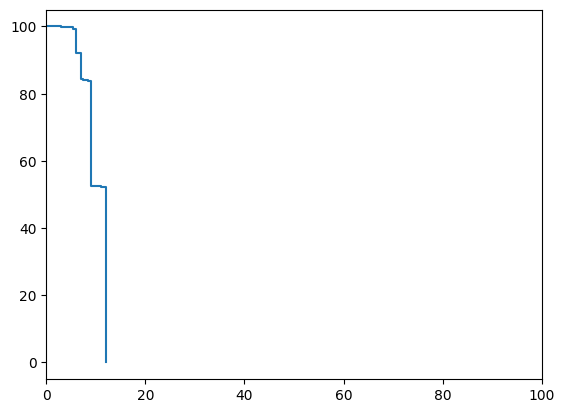

In [28]:
plt.plot(force, part_in_skeleton)
plt.xlim(0,100)

In [44]:
print(removed)
print(force)

[[], [], [], [], [], [1023], [], [84], [], [187, 1224, 1500], [], [], [], [217], [], [5080], [96], [115, 483], [1378], [1905], [], [504], [], [359, 375], [166, 346], [], [848], [], [], [], [477, 520], [585], [1268], [], [443, 2140], [149], [6384], [2364], [216, 787], [264], [172], [], [], [155], [87], [1581], [6483], [], [86, 159, 658], [183, 413], [], [], [297], [1329], [613, 3285], [1058, 3188], [], [606], [], [136], [66, 8650], [3966], [397], [3706], [330, 356], [132, 336, 2395], [101], [], [404, 755, 3104], [31, 194], [], [], [57, 1395], [], [], [142, 240, 496], [29, 52, 476, 491], [], [215], [17, 60, 205], [44, 75, 129, 1717], [123, 139], [7, 539], [180], [34, 113], []]
[0, 0.5, 1.0, 1.5, 2.0, 2.0, 2.5, 2.5, 3.0, 3.0, 3.5, 4.0, 4.5, 4.5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.5, 5.5, 6.0, 6.0, 6.0, 6.5, 6.5, 7.0, 7.5, 8.0, 8.0, 8.0, 8.0, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 9.0, 9.5, 9.5, 9.5, 9.5, 9.5, 10.0, 10.0, 10.0, 10.5, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.5, 11.5, 11.5

In [21]:
backbone1 = []

i = files[0]
print(i)
with open(i, 'r') as fid:
    for row in fid:
        row = row.split()
        # extract the fiber center (rectangular trapezoid)
        v = np.zeros(5)
        if -8 <= int(row[2]) <=8:
            if -8 <= int(row[4]) <=8:
                if -100 <= int(row[3]) <=100:
                    #print(row)
                    v = [
                        int(row[1]),  # particle id
                        int(row[2]),  # x
                        int(row[3]),  # y
                        int(row[4]),  # z                        
                    ]
                    backbone1.append(v)

backbone1 = np.array(backbone1, dtype=np.int32)
print(len(backbone1))

/home/robert/collagen_fibril/dla-collagen/files/particles/mode_s_ts_1_nb_10000_seed_30_.dat
10786


In [22]:
## Filter backbone
bb2 = filter_backbone(backbone1, ascending=True)
print('subiu')
bb3 = filter_backbone(bb2, ascending=False)
print('desceu')

np.savetxt('./bb3.txt',bb3,fmt='%d')


subiu
desceu


In [23]:
len(bb3)

4898

In [6]:
list1 = [1, 2, 3, 4]
list2 = ['a', 'b', 'c', 'd']
ts = 1
# Open a file for writing
with open('lists_%d.txt' %ts, 'w') as file:

    # Write each pair of values to a new line in the file
    for x, y in zip(list1, list2):
        file.write(f"{x}\t{y}\n")


In [40]:
act_skeleton = np.copy(bb3)
force, part_in_skeleton, Broken, brokenBonds, F = [], [], [], 0, 0
part_in_skeleton.append(len(act_skeleton))
force.append(F)
Broken.append(brokenBonds)
lenght_b = len(np.unique(act_skeleton[:,0]))
numParticles = len(act_skeleton)
restParticles = len(act_skeleton)
for i in range(0,1000):
    P = generate_probability(act_skeleton, F, 1, 2)
    #print(P) ## rods and probability of each one
    lenght_a = len(P)

    ## check if rods were removed from list
    if lenght_b == lenght_a:
        
        F += 0.5
        print('Incrementou a força: %f' %F,act_skeleton.shape[0])
    else:
        act_skeleton = act_skeleton[np.isin(act_skeleton[:,0], P)]
        restParticles = len(act_skeleton)

        if len(act_skeleton) ==  0:
            print('No particles in skeleton')
            brokenBonds =  numParticles - restParticles
            Broken.append(brokenBonds)
            force.append(F)
            part_in_skeleton.append(len(act_skeleton))
            print(F)
            print(part_in_skeleton)
            break
        
        #print('Incrementou a força: %f' %F, act_skeleton.shape[0])
        bb4 = filter_backbone(act_skeleton, ascending=True)
        #print(bb4)
        act_skeleton = filter_backbone(bb4, ascending=False)
        #print('desceu')
        lenght_b = lenght_a
        print('recalc active skeleton', act_skeleton.shape[0])

    brokenBonds =  numParticles - restParticles
    Broken.append(brokenBonds)
    force.append(F)
    part_in_skeleton.append(len(act_skeleton))
    

print(F)
print(part_in_skeleton)

Incrementou a força: 0.500000 4898
Incrementou a força: 1.000000 4898
Incrementou a força: 1.500000 4898
Incrementou a força: 2.000000 4898
Incrementou a força: 2.500000 4898
Incrementou a força: 3.000000 4898
Incrementou a força: 3.500000 4898
Incrementou a força: 4.000000 4898
recalc active skeleton 4896
recalc active skeleton 4895
Incrementou a força: 4.500000 4895
Incrementou a força: 5.000000 4895
recalc active skeleton 4870
recalc active skeleton 4869
Incrementou a força: 5.500000 4869
Incrementou a força: 6.000000 4869
recalc active skeleton 4868
recalc active skeleton 4618
recalc active skeleton 4617
recalc active skeleton 4616
Incrementou a força: 6.500000 4616
Incrementou a força: 7.000000 4616
recalc active skeleton 4615
recalc active skeleton 4614
recalc active skeleton 4612
Incrementou a força: 7.500000 4612
recalc active skeleton 4611
recalc active skeleton 4610
Incrementou a força: 8.000000 4610
recalc active skeleton 4608
recalc active skeleton 4606
recalc active skelet

/tmp/ipykernel_5676/1485982156.py:144: RuntimeWarning: divide by zero encountered in double_scalars
  P = (sigma_/N_*sigma_c)**m


In [41]:
Broken = np.array(Broken)
#Broken = Broken - Broken[0]len()
print(len(Broken))
print(len(force))

132
132


ValueError: x and y must have same first dimension, but have shapes (76,) and (75,)

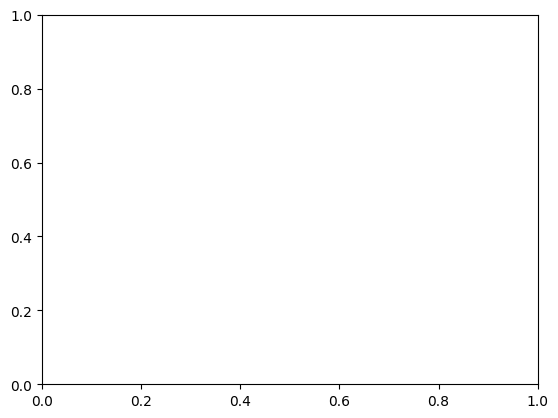

In [29]:
plt.plot(force, Broken)
plt.xlim(0,100)

In [41]:
len(bb4)

2

In [61]:
16*16*200

51200

In [51]:
print(len(force))
print(len(part_in_skeleton))
part_in_skeleton = np.array(part_in_skeleton)/part_in_skeleton[0] * 100

503
503


In [24]:

f0 = force
p0 = part_in_skeleton

In [39]:
f10 = force
p10 = part_in_skeleton

In [58]:
f100 = force
p100 = part_in_skeleton

(0.0, 105.0)

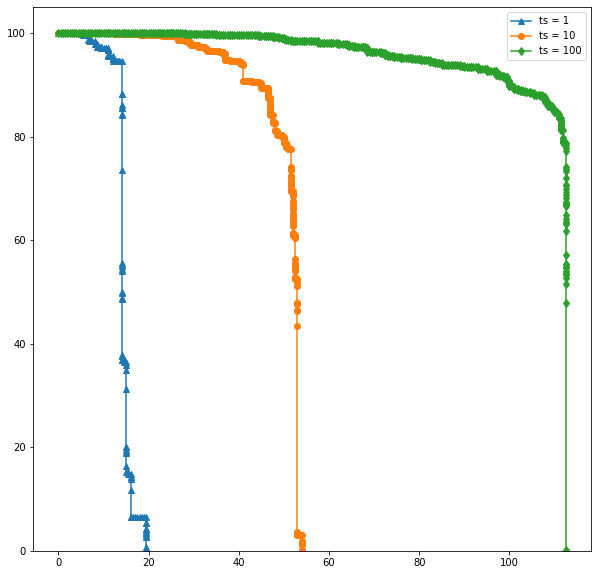

In [60]:
plt.figure(figsize=(10,10))
plt.plot(f0,p0,'-^', label = 'ts = 1')
plt.plot(f10,p10,'-o', label = 'ts = 10')
plt.plot(f100,p100,'-d', label = 'ts = 100')
#plt.plot(force,part_in_skeleton, '-v', label = 'ts = 1000')
plt.legend(loc = 'best')
#plt.xlim(0,400)
plt.ylim(0,105)
#plt.plot(force, part_in_skeleton, 'o--r')


ValueError: Expected 1D or 2D array, got 3D array instead

In [601]:
P

array([[0.00000000e+00, 9.49119720e-05, 0.00000000e+00],
       [1.00000000e+00, 1.36673240e-04, 0.00000000e+00],
       [2.00000000e+00, 7.16720012e-05, 0.00000000e+00],
       ...,
       [9.94500000e+03, 1.27223512e-03, 0.00000000e+00],
       [9.95900000e+03, 1.09439811e-03, 0.00000000e+00],
       [9.97900000e+03, 4.84111267e-03, 0.00000000e+00]])

In [577]:
print(sort)
print(type(P))
print(np.where(np.array(sort) == 1))
to_remove = P[np.array(sort) == 1] 
print(to_remove)

if(len(bb4) == 2):
            print('entrou')
            force.append(F)
            part_in_skeleton.append(len(act_skeleton))
            break

[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 

In [571]:
from scipy.stats import bernoulli

# create a Bernoulli distribution with probability of success p=0.7
p = 0.7
dist = bernoulli(p)

# compute the probability of success
prob_success = dist.pmf(1)   # returns 0.7

# generate a random sample of 10 outcomes
random_sample = dist.rvs(size=10)

# compute the mean of the random sample (should be close to p)
mean = random_sample.mean()

# print the results
print("Probability of success:", prob_success)
print("Random sample:", random_sample)
print("Sample mean:", mean)

from scipy.stats import bernoulli

# create a Bernoulli distribution with probability of success p=0.3
p = 0.3
dist = bernoulli(p)

# compute the PMF of the distribution
pmf = [dist.pmf(k) for k in range(2)]

# print the results
print("Bernoulli distribution with p=", p)
print("PMF:", pmf)


Probability of success: 0.7
Random sample: [0 1 1 1 1 0 1 1 1 0]
Sample mean: 0.7
Bernoulli distribution with p= 0.3
PMF: [0.7, 0.3]


In [495]:
bb3

array([[ 999,    2, -100,    3],
       [3123,   -1, -100,   -4],
       [1570,   -3, -100,    4],
       ...,
       [1358,   -2,  100,    5],
       [1158,    5,  100,    4],
       [5165,    4,  100,   -8]], dtype=int32)

In [479]:
back_bone = np.copy(bb3)
i = 999
vizinhos = [back_bone[np.sum((i - back_bone[:,1:])**2,axis = 1) == 1]]
print(type(vizinhos))

<class 'list'>


In [ ]:
## Test for filter_backbone

m = [[0,0,0,1], [1,1,0,1], [2, 2, 0, 1], [3, 1, 0, 3], [4, 1,1,1], [5, 2, 1, 1], [6, 2,1,1], [7, 0,1,1], [8, 1,1,2],[9, 3, 1, 1], [10, 2, 1, 0], [11, 5, 1, 1]
, [12, 0, 1, 4],   [13, 0, 2, 4] ]
v = np.array(m, dtype=np.int8)

v = v[v[:,2].argsort()]
print(v)

bt = filter_backbone(v, ascending= False)


In [472]:
## Filter fibril
bb2 = filter_backbone(backbone1, ascending=True)
print('subiu')
bb3 = filter_backbone(bb2, ascending=False)
print('desceu')

np.savetxt('./bb3.txt',bb3,fmt='%d')


subiu
desceu


In [507]:
## Remove rods from the backbone

t = []
r = []
f = []
back_bone1 = np.copy(bb3)
for F in range(400,550,10):
    
    print(F)
    probabilidade = generate_probability(back_bone1,F,sigma_c = 1,m = 2)
    if(len(probabilidade) == 0):
        break
    remove_ = probabilidade[probabilidade[:,1] >= 1][:,0]
    #r.append(len(remove_))
    #f.append(F)

    probabilidade = probabilidade[probabilidade[:,1] < 1]

    for i in remove_:
        back_bone1 = back_bone1[back_bone1[:,0] != i]
    t.append(np.sum(probabilidade[:,-1]))
t = np.array(t)

400
410
420
430
440
450
460
470


In [ ]:
#plt.figure(figsize = (10,10))
plt.grid(True)
plt.plot(np.array(range(0,len(ts1)*10,10)),ts1/ts1[0], label = 'ts = 1')
plt.plot(np.array(range(200,440,10)),ts1000/ts1000[0], label = 'ts = 1000')
plt.legend(loc='best')
plt.xlabel('Force applied to skeleton (F)')
plt.ylabel('% particules in skeleton')

#plt.xlim(0,400)
plt.show()

In [607]:
backbone1 = np.array(bb3).astype(int)
back_bone,N = filter_backbone(backbone1,-100,+1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone])
back_bone,N = filter_backbone(back_bone,100,-1)
back_bone = [backbone1[np.where(np.all(i == backbone1[:,1:-1],axis = 1))[0]] for i in back_bone]
back_bone = np.array([i[0].tolist() for i in back_bone]).astype(int)

In [593]:
def remover(vetor,elemento):
    a = np.arange(len(vetor))
    a = a[vetor == elemento]
    print(a)
    return a

In [338]:
bb3

array([[ 999,    2, -100,    3],
       [3123,   -1, -100,   -4],
       [1570,   -3, -100,    4],
       ...,
       [1358,   -2,  100,    5],
       [1158,    5,  100,    4],
       [5165,    4,  100,   -8]], dtype=int32)

In [392]:
np.all(np.array([[1,233,3],[4,5,6]]) in np.array([[1,8888,3],[4,5,6]]))

True

In [393]:
def calc_vizinho(back_bone,altura,camada):
    camada = [back_bone[np.sum((i - back_bone[:,1:])**2,axis = 1) == 1].tolist() for i in camada]
    camada = [i for i in camada if(i != [])]
    camada = [item for sublist in camada for item in sublist]
    camada = np.array([i for i in camada if(i[0] >altura)])
    return camada

In [467]:
def generate_back_bone2(back_bone1,inicial):
    back_bone2 = []

    back_bone1 = np.array(back_bone1).astype(int)

    #Primeira camada,
    camada = back_bone1[back_bone1[:,2] == inicial][:,1:]
    back_bone2 += camada.tolist()
    altura = inicial
    while(camada.shape[0] !=0):
        camada = [back_bone1[np.sum((i - back_bone1[:,1:])**2,axis = 1) == 1][:,1:].tolist() for i in camada]
        camada = [i for i in camada if(i != [])]
        camada = [item for sublist in camada for item in sublist]
        if(inicial <0):
            camada = np.array([i for i in camada if(i[1] >altura)])
            altura += 1
        else:
            camada = np.array([i for i in camada if(i[1] < altura)])
            altura -= 1
        if(camada.shape[0] ==0):
            break
        vizinhos = [back_bone1[np.sum((i - back_bone1[:,1:])**2,axis = 1) == 1][:,1:].tolist() for i in camada]
        vizinhos = [i for i in vizinhos if(i != [])]
        vizinhos = [item for sublist in vizinhos for item in sublist]
        vizinhos = np.array([i for i in vizinhos if(i[1] == altura)])
        camada = np.vstack((camada,vizinhos))
        final = []
        for i in camada:
            if(i.tolist() not in final):
                final.append(i.tolist())
        camada = np.array(final)
        if(camada.shape[0] !=0):
            back_bone2 += camada.tolist()
    return back_bone2

In [468]:
backbone = generate_back_bone2(backbone1,-100)
print(backbone)
#backbone = generate_back_bone2(backbone,-100)

NameError: name 'back_bone' is not defined

In [469]:
backbone

[[-1, -100, 0],
 [-1, -100, 1],
 [0, -100, 1],
 [0, -100, 0],
 [-1, -100, 2],
 [0, -100, -1],
 [-2, -100, 0],
 [-1, -100, 3],
 [-2, -100, 1],
 [0, -100, 2],
 [1, -100, 2],
 [-1, -100, -2],
 [0, -100, 3],
 [1, -100, 1],
 [1, -100, 3],
 [0, -100, -2],
 [1, -100, 0],
 [1, -100, -1],
 [-3, -100, 1],
 [-3, -100, 0],
 [1, -100, -2],
 [1, -100, 4],
 [-1, -100, 4],
 [-2, -100, 4],
 [1, -100, 5],
 [-2, -100, -2],
 [-3, -100, -2],
 [-4, -100, 1],
 [-4, -100, 0],
 [-4, -100, -1],
 [-4, -100, -2],
 [-1, -100, 5],
 [2, -100, 1],
 [2, -100, 2],
 [2, -100, 3],
 [2, -100, 4],
 [2, -100, 5],
 [3, -100, 1],
 [-4, -100, 4],
 [3, -100, 0],
 [-1, -100, -3],
 [2, -100, 0],
 [2, -100, -1],
 [-5, -100, 4],
 [-2, -100, -3],
 [3, -100, -1],
 [-3, -100, -3],
 [2, -100, -2],
 [3, -100, -2],
 [-4, -100, -3],
 [2, -100, 6],
 [-3, -100, 4],
 [4, -100, -1],
 [4, -100, -2],
 [4, -100, 0],
 [1, -100, 6],
 [-5, -100, 0],
 [-3, -100, 5],
 [4, -100, 1],
 [-5, -100, -1],
 [-5, -100, -2],
 [-6, -100, -1],
 [-4, -100, 5],
 [

In [353]:
t = []
back_bone1 = np.copy(bb3)
for F in range(200,550,10):
    
    print(F)
    probabilidade = generate_probability(back_bone1,F,sigma_c = 1,m = 2)
    if(len(probabilidade) == 0):
        break
    remove_ = probabilidade[probabilidade[:,1] >= 1][:,0]
    probabilidade = probabilidade[probabilidade[:,1] < 1]

    for i in remove_:
        back_bone1 = back_bone1[back_bone1[:,0] != i]
    t.append(np.sum(probabilidade[:,-1]))
t = np.array(t)

200
[27850.0]
210
[27850.0, 27850.0]
220
[27850.0, 27850.0, 27850.0]
230
[27850.0, 27850.0, 27850.0, 27850.0]
240
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0]
250
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0]
260
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0]
270
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0]
280
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0]
290
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0]
300
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0]
310
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0, 26223.0]
320
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0, 26223.0, 25973.0]
330
[27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27850.0, 27788.0, 27601.0, 27313.0, 26861.0, 26499.0, 26223.0, 259

In [341]:
t[-1]

0

In [ ]:
ts1000 = np.copy(t)

In [348]:
ts1000/ts1000[0]

array([1.        , 0.9780127 , 0.9598796 , 0.9505194 , 0.94541717,
       0.93928716, 0.91337224, 0.86238667, 0.72110267, 0.52013361,
       0.35664207, 0.21888191, 0.08431524, 0.00132144, 0.        ])

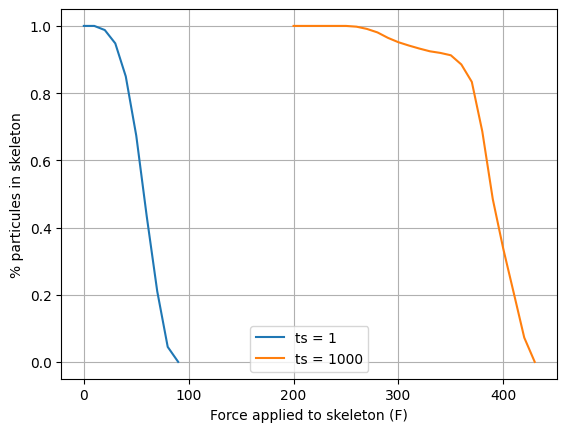

In [361]:
#plt.figure(figsize = (10,10))
plt.grid(True)
#plt.plot(np.array(range(0,len(ts1)*10,10)),ts1/ts1[0], label = 'ts = 1')
plt.plot(np.array(range(200,440,10)),ts1000/ts1000[0], label = 'ts = 1000')
plt.legend(loc='best')
plt.xlabel('Force applied to skeleton (F)')
plt.ylabel('% particules in skeleton')

#plt.xlim(0,400)
plt.show()

In [443]:
backbone = back_bone.astype(int)

In [448]:
back_bone[back_bone[:,2] == 10]

array([[182.,   0.,  10.,  -5.,   0.],
       [ 22.,   1.,  10.,   2.,   0.],
       [  4.,   1.,  10.,  -1.,   0.],
       [ 37.,   0.,  10.,   1.,   0.],
       [ 53.,   0.,  10.,  -4.,   0.],
       [  8.,   2.,  10.,  -1.,   0.],
       [156.,   3.,  10.,  -1.,   0.],
       [ 89.,  -1.,  10.,   1.,   0.],
       [125.,   3.,  10.,  -2.,   0.],
       [ 30.,   1.,  10.,   3.,   0.]])

[array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape=(0, 5), dtype=float64),
 array([], shape

In [ ]:
with open("/home/robert/gitrepos/dla-collagen/back_bone_teste.txt", 'w') as fid:
    for i in back_bone1:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

In [ ]:
np.savetxt("./back.txt", back_bone[:,1:-1],fmt = "%d", delimiter=' ')

In [ ]:
back_bone

array([[ 237,   -4,  100,    4,    0],
       [2213,   -2,  100,   -7,    0],
       [3577,   -2,  100,   -5,    0],
       ...,
       [2660,    1, -100,   -8,    0],
       [5179,    4, -100,    1,    0],
       [ 979,   -5, -100,   -5,    0]])

In [ ]:
##

F = 1
stress_i = np.array(201)


array([[  1, -99,   0],
       [  0, -99,   0],
       [ -1, -99,   1],
       [ -1, -99,  -4],
       [ -2, -99,  -4],
       [  0, -99,  -4],
       [  0, -99,  -3],
       [  4, -99,  -2],
       [ -4, -99,   1],
       [ -3, -99,   1],
       [  5, -99,  -2],
       [ -5, -99,   0],
       [ -3, -99,   0],
       [  2, -99,   2],
       [ -6, -99,   0],
       [ -7, -99,   0],
       [  3, -99,  -7],
       [ -7, -99,  -1],
       [  5, -99,  -1],
       [  5, -99,   0],
       [  6, -99,  -1],
       [  0, -99,   6],
       [ -3, -99,  -4],
       [  1, -99,  -4],
       [ -4, -99,  -4],
       [  6, -99,  -5],
       [  7, -99,  -5],
       [ -5, -99,  -4],
       [  0, -99,   7],
       [ -4, -99,  -5],
       [  6, -99,  -4],
       [  9, -99,  -7],
       [  7, -99,  -4],
       [  5, -99,   6],
       [  9, -99,  -8],
       [ -1, -99,   7],
       [  8, -99,  -8],
       [ -2, -99,   7],
       [  5, -99,   7],
       [ -7, -99,   4],
       [  8, -99,  -4],
       [  7, -99

(47, 3)

In [ ]:
#print(len(back_bone1))
back_bone2 = []
print('tamanho back_bone1: %d' %len(back_bone1))

### Encotra todas as part. da primeira camada(y = -100) e marca como conectado
for j in back_bone1:
            
    if j[2] == -100:
        #print(entrou)
        part = [j[0], j[1], j[2], j[3], j[4] +1]
        back_bone2.append(part)
        #print(back_bone2)

    else:
        continue

### Encontra os vizinhos na segunda camada das part. marcadas na primeira camada
layer = []
plane = []
for i in back_bone2:
    part = [i[0], i[1], i[2]  + 1, i[3], i[4]]
    
    for j in back_bone1:

        if part[1] == j[1] and part[2] == j[2] and part[3] == j[3]:
            part[4] = 1
            layer.append(part)
        
print(len(layer))

### Encontra os vizinhos das part. na segunda camada
print(len(layer))
for i in layer:
    neigh1 = [i[0], i[1] + 1, i[2], i[3], i[4]]
    neigh2 = [i[0], i[1] - 1, i[2], i[3], i[4]]
    neigh3 = [i[0], i[1], i[2], i[3] + 1, i[4]]
    neigh4 = [i[0], i[1], i[2], i[3] - 1, i[4]]


    for j in back_bone1:

        if neigh1[1] == j[1]:
            if neigh1[2] == j[2]:
                if neigh1[3] == j[3]:
                    neigh1[4] = 1
                    layer.append(neigh1)

        if neigh2[1] == j[1]:
            if neigh2[2] == j[2]:
                if neigh2[3] == j[3]:
                    neigh2[4] = 1
                    layer.append(neigh2)

        if neigh3[1] == j[1]:
            if neigh3[2] == j[2]:
                if neigh3[3] == j[3]:
                    neigh3[4] = 1
                    layer.append(neigh3)

        if neigh4[1] == j[1]:
            if neigh4[2] == j[2]:
                if neigh4[3] == j[3]:
                    neigh4[4] = 1
                    layer.append(neigh4)



        

#print('plane: %d' %len(plane))
print(len(layer))
### Adiciona as part. conectadas da segunda camada no back_bone2


tamanho back_bone1: 8431
45
45


KeyboardInterrupt: 

In [ ]:
for i in back_bone1:
    if i[2] == -99:
        #print(i)
        #print(type(i))
        c = 0
a = [112, -1, -98, 1, 0]
if a in back_bone1:
    print("ok")
else:
    print('no')


no


In [ ]:
part = [51.0, 0.0, -99.0, 0.0, 1]
for i in back_bone1:
    if part[1] == i[1] and part[2] == i[2] and part[3] == i[3]:
        print(part)
        print(i)

[51.0, 0.0, -99.0, 0.0, 1]
[51.0, 0.0, -99.0, 0.0, 0.0]


In [ ]:
for i in back_bone1:

    if i[2] == -99:
        print(i)

[51.0, 0.0, -99.0, 0.0, 0.0]
[112.0, -2.0, -99.0, 1.0, 0.0]
[136.0, -2.0, -99.0, -4.0, 0.0]
[138.0, -3.0, -99.0, -4.0, 0.0]
[144.0, -1.0, -99.0, -4.0, 0.0]
[171.0, -1.0, -99.0, -3.0, 0.0]
[196.0, 3.0, -99.0, -2.0, 0.0]
[248.0, -5.0, -99.0, 1.0, 0.0]
[287.0, 4.0, -99.0, -2.0, 0.0]
[302.0, -6.0, -99.0, 0.0, 0.0]
[313.0, -4.0, -99.0, 0.0, 0.0]
[338.0, 1.0, -99.0, 2.0, 0.0]
[355.0, 4.0, -99.0, -5.0, 0.0]
[414.0, -7.0, -99.0, 0.0, 0.0]
[417.0, -8.0, -99.0, 0.0, 0.0]
[420.0, 2.0, -99.0, -7.0, 0.0]
[437.0, -8.0, -99.0, -1.0, 0.0]
[438.0, 4.0, -99.0, -1.0, 0.0]
[458.0, 4.0, -99.0, 0.0, 0.0]
[470.0, 5.0, -99.0, -1.0, 0.0]
[549.0, -4.0, -99.0, 5.0, 0.0]
[553.0, -1.0, -99.0, 6.0, 0.0]
[584.0, -4.0, -99.0, -4.0, 0.0]
[674.0, 0.0, -99.0, -4.0, 0.0]
[698.0, -5.0, -99.0, -4.0, 0.0]
[704.0, 5.0, -99.0, -5.0, 0.0]
[758.0, 6.0, -99.0, -5.0, 0.0]
[764.0, -6.0, -99.0, -4.0, 0.0]
[905.0, -1.0, -99.0, 7.0, 0.0]
[979.0, -5.0, -99.0, -5.0, 0.0]
[1003.0, 5.0, -99.0, -4.0, 0.0]
[1046.0, 8.0, -99.0, -7.0, 0.0]
[

In [ ]:
#print(back_bone2)
with open("/home/robert/gitrepos/dla-collagen/back_bone2_teste.txt", 'w') as fid:
    for i in back_bone2:
        x = str(int(i[1]))
        y = str(int(i[2]))
        z = str(int(i[3]))
        fid.write('%s %s %s \n' %(x,y,z))

[[51.0, 0.0, -99.0, 0.0, 0], [67.0, -1.0, -99.0, 0.0, 0], [112.0, -2.0, -99.0, 1.0, 0], [136.0, -2.0, -99.0, -4.0, 0], [138.0, -3.0, -99.0, -4.0, 0], [144.0, -1.0, -99.0, -4.0, 0], [171.0, -1.0, -99.0, -3.0, 0], [196.0, 3.0, -99.0, -2.0, 0], [248.0, -5.0, -99.0, 1.0, 0], [271.0, -4.0, -99.0, 1.0, 0], [287.0, 4.0, -99.0, -2.0, 0], [302.0, -6.0, -99.0, 0.0, 0], [313.0, -4.0, -99.0, 0.0, 0], [338.0, 1.0, -99.0, 2.0, 0], [414.0, -7.0, -99.0, 0.0, 0], [417.0, -8.0, -99.0, 0.0, 0], [420.0, 2.0, -99.0, -7.0, 0], [437.0, -8.0, -99.0, -1.0, 0], [438.0, 4.0, -99.0, -1.0, 0], [458.0, 4.0, -99.0, 0.0, 0], [470.0, 5.0, -99.0, -1.0, 0], [553.0, -1.0, -99.0, 6.0, 0], [584.0, -4.0, -99.0, -4.0, 0], [674.0, 0.0, -99.0, -4.0, 0], [698.0, -5.0, -99.0, -4.0, 0], [704.0, 5.0, -99.0, -5.0, 0], [758.0, 6.0, -99.0, -5.0, 0], [764.0, -6.0, -99.0, -4.0, 0], [905.0, -1.0, -99.0, 7.0, 0], [979.0, -5.0, -99.0, -5.0, 0], [1003.0, 5.0, -99.0, -4.0, 0], [1046.0, 8.0, -99.0, -7.0, 0], [1065.0, 6.0, -99.0, -4.0, 0], [1